In [1]:
import numpy as np
import pandas as pd
import ecco_v4_py as ecco
import xarray as xr
from scipy.spatial import KDTree, cKDTree
import swot_ssh_utils as swot
import matplotlib.pyplot as plt
import sys
sys.path.append('/home3/sreich/MITgcm_c68w/MITgcm/utils/python/MITgcmutils')
from MITgcmutils import rdmds

from patchface3D import *
%load_ext autoreload
%autoreload 2

### Read in Grid Data

In [2]:
sNx=90
sNy=90

#grid_dir='/scratch/shoshi/MITgcm_c68p/llc90/run_obsfit_pk0000205956/'
grid_dir='/nobackup/sreich/llc1080_c68w_runs/run/'
hfc = rdmds(grid_dir+'hFacC', lev=0)
hfc[hfc!=0]=np.nan
# Convert to dict of 5 faces, sizes [(270,90), (270,90), (90,90), (90,270), (90,270)]
hfc_faces = ecco.llc_compact_to_faces(hfc, less_output=True)

xc = rdmds(grid_dir+'XC')
yc = rdmds(grid_dir+'YC')


### Read in SWOT Data

In [4]:
# load swot data
pth = '/nobackup/sreich/swot/SWOT_L2_LR_SSH_2.0/'
filename = 'SWOT_L2_LR_SSH_Expert_009_001_20240104T033426_20240104T042554_PIC0_01.nc'

ds_swot = xr.open_dataset(pth + filename)
ds_swot = ds_swot.drop_dims('num_sides')
ds_swot['longitude'] = (ds_swot['longitude'] + 180) % 360 - 180
# swot_coords = np.c_[ds_swot.latitude.values.ravel(), ds_swot.longitude.values.ravel()]

# swot_coords.shape


In [5]:
ds_swot_sub = ds_swot.where(ds_swot.ancillary_surface_classification_flag == 0, drop=True)
#ds_swot_sub['longitude'] = (ds_swot_sub['longitude'] + 180) % 360 - 180
swot_coords = np.c_[ds_swot_sub.latitude.values.ravel(), ds_swot_sub.longitude.values.ravel()]

swot_coords.shape


(484587, 2)

In [6]:
# apply corrections
ssha = ds_swot_sub.ssha_karin_2
flag = ds_swot_sub.ancillary_surface_classification_flag
ssha = np.where(flag == 0, ssha, np.nan)

distance = ds_swot_sub.cross_track_distance.values

ssha = swot.fit_bias(
        ssha, distance,
        check_bad_point_threshold=0.1,
        remove_along_track_polynomial=True
    )

ds_swot_sub.ssha_karin_2.values = ssha

In [7]:
ds_swot_sub

<xarray.Dataset>
Dimensions:                                (num_lines: 7023, num_pixels: 69)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 -7...
    longitude                              (num_lines, num_pixels) float64 -5...
    latitude_nadir                         (num_lines) float64 -76.19 ... 77.67
    longitude_nadir                        (num_lines) float64 303.4 ... 83.89
Dimensions without coordinates: num_lines, num_pixels
Data variables: (12/90)
    time                                   (num_lines, num_pixels) datetime64[ns] ...
    time_tai                               (num_lines, num_pixels) datetime64[ns] ...
    ssh_karin                              (num_lines, num_pixels) float64 na...
    ssh_karin_qual                         (num_lines, num_pixels) float64 4....
    ssh_karin_uncert                       (num_lines, num_pixels) float32 na...
    ssha_karin                             (num_lines, num_pixels) float64 na...
    ...                                     ...
    swh_ssb_cor_source                     (num_lines, num_pixels) float32 0....
    swh_ssb_cor_source_2                   (num_lines, num_pixels) float32 0....
    wind_speed_ssb_cor_source              (num_lines, num_pixels) float32 0....
    wind_speed_ssb_cor_source_2            (num_lines, num_pixels) float32 0....
    volumetric_correlation                 (num_lines, num_pixels) float32 na...
    volumetric_correlation_uncert          (num_lines, num_pixels) float32 na...
Attributes: (12/62)
    Conventions:                                   CF-1.7
    title:                                         Level 2 Low Rate Sea Surfa...
    institution:                                   CNES
    source:                                        Ka-band radar interferometer
    history:                                       2024-01-06T22:00:22Z : Cre...
    platform:                                      SWOT
    ...                                            ...
    ellipsoid_semi_major_axis:                     6378137.0
    ellipsoid_flattening:                          0.0033528106647474805
    good_ocean_data_percent:                       60.48776497534297
    ssha_variance:                                 0.9238074834420934
    references:                                    V1.2.1
    equator_longitude:                             0.17

Text(0.5, 1.0, 'SWOT SSH')

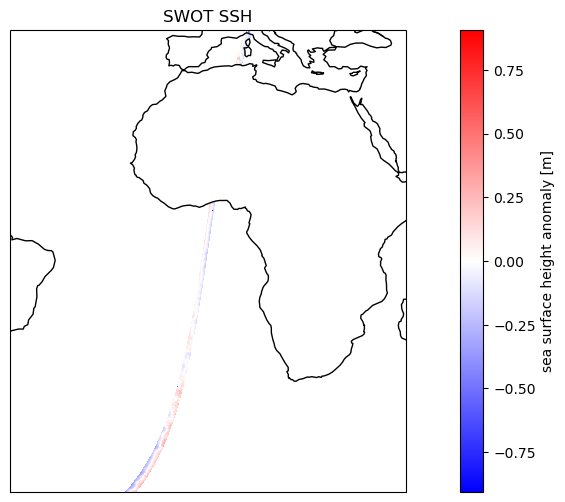

In [15]:
import cartopy
import cartopy.crs as ccrs
cartopy.config['data_dir']='/home3/sreich/.local/share/cartopy'
cartopy.config['pre_existing_data_dir']='/home3/sreich/.local/share/cartopy'

plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ds_swot_sub.ssha_karin_2.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude", cmap='bwr',add_colorbar=True
)
ax.coastlines()
ax.set_ylim([-60, 45])
ax.set_xlim([-45,45])
plt.title('SWOT SSH')

### Compute _interp fields

translated from /home/atnguyen/llc270/global/matlab/simple_ctd/

step02:
- xc and yc are reshaped from compact (nx, 13*nx) to worldmap (4*nx, 4*nx)
- prof_point/nearest_swot_index is computed relative to worldmap view
  
step04
- Line 43/44: xc and yc are turned from (4*nx, 4*nx) to 5-face view. Use patchface3D_wrld_to_5f. This is "direction 3" in matlab script patchface3D.m 
- FOR face = 1..5: Do the [X,Y]C[11,NINJ] routine
- Line 68: (I think — convince yourself) sneakily turn each [X,Y]C[11,NINJ] field from 5-face  to compact
- Line 69: Change each field from compact to worldmap (she has done so in her python function)
- Line 70: Use the prof_point (which was created relative to worldmap view) to grab the index from each field, which are now properly in worldmap view.

In [16]:
# step02:

# reshape xc, yc from compact (13*nx, nx) form to worldmap view (nz=1,4*nx, 4*nx)
nx = 1080

xc = rdmds(grid_dir+'XC')
yc = rdmds(grid_dir+'YC')

xc = patchface3D(xc,nx,1)
yc = patchface3D(yc,nx,1)

llc_coords = np.c_[yc.ravel(), xc.ravel()]

# compute nearest_swot_index relative to worldmap view
kd_tree = KDTree(llc_coords)
distance, nearest_swot_index_in_llc = kd_tree.query(swot_coords, k=1)



1
(1080, 3240, 1)
1
(1080, 3240, 1)


1
(1080, 3240, 1)


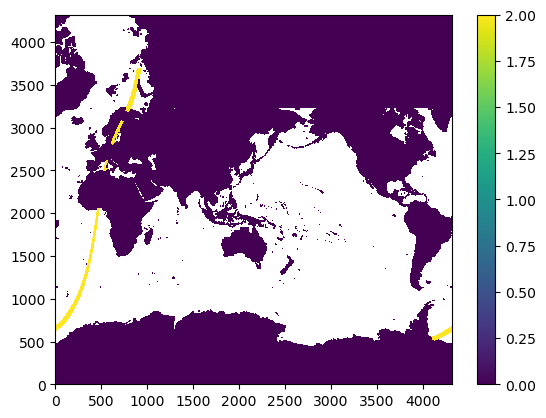

In [17]:
# plot to check 
#grid_dir='/scratch/shoshi/MITgcm_c68p/llc90/run_obsfit_pk0000205956/'
#hfc = rdmds(grid_dir+'hFacC', lev=0)
hfc_wrl = patchface3D(hfc, nx, 1)[0,:,:]
hfc_wrl.ravel()[nearest_swot_index_in_llc]= 2
#plt.pcolor(hfc_wrl*patchface3D(hfc, nx, 1)[0,:,:])
plt.pcolor(hfc_wrl)
plt.colorbar()

In [ ]:
# kd_tree = KDTree(llc_coords)
# import time
# # tic = time.perf_counter()
# # distance, nearest_swot_index_in_llc = kd_tree.query(swot_coords[:200000], k=1)
# # toc = time.perf_counter()
# # print(f"{toc - tic:0.4f} seconds")

# # tic = time.perf_counter()
# # distance, nearest_swot_index_in_llc = kd_tree.query(swot_coords[200000:400000], k=1)
# # toc = time.perf_counter()
# # print(f"{toc - tic:0.4f} seconds")

# tic = time.perf_counter()
# #distance, nearest_swot_index_in_llc = kd_tree.query(swot_coords[370000:380000], k=1)
# distance, nearest_swot_index_in_llc = kd_tree.query(swot_coords, k=1)
# toc = time.perf_counter()
# print(f"{toc - tic:0.4f} seconds")

# ############
# llc_coords.shape, swot_coords.shape
# #swot_coords[370000:380000]
# swot_coords.shape

# #ds_swot.where(~np.isnan(ds_swot.ssha_karin_2), drop=True)
# ############

# #(~np.isnan(ds_swot.ssha_karin_2) * ds_swot.latitude).plot()

# mask = ~np.isnan(ds_swot.ssha_karin_2)
# #mask[mask==0]=np.nan
# #(mask.where(mask==True).values * ds_swot.latitude).plot()


# ~np.isnan(ds_swot.ssha_karin_2) * ds_swot.latitude

# lats = mask.where(mask==True).values * ds_swot.latitude
# lons = mask.where(mask==True).values * ds_swot.longitude

# swot_coords = np.c_[lats.values.ravel(), lons.values.ravel()]

# swot_coords.shape

# ############

# nan_mask = np.isnan(swot_coords).all(axis=1)

# # Invert the mask to keep rows where at least one element is not nan
# valid_rows = ~nan_mask

# # Filter out rows with nan elements
# cleaned_array = swot_coords[valid_rows]
# cleaned_array.shape




In [18]:
### step 4 ###

# transform xc and yc from worldmap (4*nx, 4*nx) to 5-face view
tileCount=0

xgrid = patchface3D_wrld_to_5f(xc)
ygrid = patchface3D_wrld_to_5f(yc)

for i in range(1,6):
    xgrid[i] = np.squeeze(xgrid[i])
    ygrid[i] = np.squeeze(ygrid[i])

XC11=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))
YC11=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))
XCNINJ=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))
YCNINJ=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))
iTile=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))
jTile=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))
tileNo=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))

# FOR face = 1..5: Do the [X,Y]C[11,NINJ] routine
for key in xgrid.keys():
    face_XC = xgrid[key] 
    face_YC = ygrid[key]
    for ii in range(int(face_XC.shape[1]/sNx)):
        for jj in range(int(face_XC.shape[0]/sNy)):
            tileCount += 1
            tmp_i = np.arange(sNx)+sNx*ii
            tmp_j = np.arange(sNy)+sNx*jj
            tmp_XC = face_XC[ np.ix_( tmp_j, tmp_i ) ]
            tmp_YC = face_YC[ np.ix_( tmp_j, tmp_i ) ]
            XC11[key][ np.ix_( tmp_j, tmp_i ) ] = tmp_XC[0,0]
            YC11[key][ np.ix_( tmp_j, tmp_i ) ] = tmp_YC[0,0]
            XCNINJ[key][ np.ix_( tmp_j, tmp_i ) ] = tmp_XC[-1,-1]
            YCNINJ[key][ np.ix_( tmp_j, tmp_i ) ] = tmp_YC[-1,-1]
            iTile[key][ np.ix_( tmp_j, tmp_i ) ] = np.ones((sNx,1)) * np.arange(1,sNy+1)
            jTile[key][ np.ix_( tmp_j, tmp_i ) ] = (np.arange(1,sNx+1) * np.ones((sNy,1))).T
            tileNo[key][ np.ix_( tmp_j, tmp_i ) ] = tileCount*np.ones((sNy,sNx))




In [19]:
tile_keys = ['XC11', 'YC11', 'XCNINJ', 'YCNINJ', 'i', 'j']
tile_vals = [XC11, YC11, XCNINJ, YCNINJ, iTile, jTile]
tile_data_in = dict(zip(tile_keys, tile_vals))
tile_dict = dict()
for key in tile_keys:

    # - Line 68: sneakily turn each [X,Y]C[11,NINJ] field from 5-face  to compact
    temp = tile_data_in[key]
    temp = np.concatenate((temp[1], temp[2], temp[3], temp[4].T, temp[5].T))

    # - Line 69: Change each field from compact to worldmap (she has done so in her python function)
    tile_data_in[key] = patchface3D(temp,nx,1)

    # - Line 70: Use the obs_point (which was created relative to worldmap view) to grab the index from each field, 
    # which are now properly in worldmap view.
    tile_dict['sample_interp_' + key] = tile_data_in[key].ravel()[nearest_swot_index_in_llc]

1
(1080, 3240, 1)
1
(1080, 3240, 1)
1
(1080, 3240, 1)
1
(1080, 3240, 1)
1
(1080, 3240, 1)
1
(1080, 3240, 1)


In [20]:
tile_dict['sample_interp_XC11'].shape, tile_dict

((484587,),
 {'sample_interp_XC11': array([-90.45833588, -90.45833588, -90.45833588, ...,  75.55693817,
          75.55693817,  75.55693817]),
  'sample_interp_YC11': array([-70.01290131, -70.01290131, -70.01290131, ...,  74.41401672,
          74.41401672,  74.41401672]),
  'sample_interp_XCNINJ': array([-83.30690002, -83.30690002, -83.30690002, ...,  83.24832153,
          83.24832153,  83.24832153]),
  'sample_interp_YCNINJ': array([-72.4388504 , -72.4388504 , -72.4388504 , ...,  78.15738678,
          78.15738678,  78.15738678]),
  'sample_interp_i': array([54., 54., 57., ..., 87., 87., 87.]),
  'sample_interp_j': array([85., 85., 86., ..., 59., 59., 59.])})

### Add obs_interp_ fields to data

In [21]:
# reshape for num_lines, num_pixels
for key in tile_dict.keys():
    tile_dict[key] = tile_dict[key].reshape(ds_swot_sub.ssh_karin_2.shape)

# add interp fields to xarray
for key, item in tile_dict.items():
    dims = ('num_lines', 'num_pixels')  # Replace with your actual dimension names
    var_da = xr.DataArray(item, dims=dims, name=key)
    ds_swot_sub[key] = var_da

In [22]:
# up until this point, we have obsfit fields for each individual swot point
# now can group and average all swot ssha values in same llc grid square

df_swot = ds_swot_sub.to_dataframe()
gb = df_swot.groupby(['sample_interp_XC11', 'sample_interp_YC11', 'sample_interp_XCNINJ', 'sample_interp_YCNINJ', 'sample_interp_i', 'sample_interp_j'])
counts = gb.size().to_frame(name='counts')
gb_stats = (counts
.join(gb.agg({'ssha_karin_2': 'mean'}).rename(columns={'ssha_karin_2': 'obs_val'}))
.join(gb.agg({'ssha_karin_2': 'std'}).rename(columns={'ssha_karin_2': 'ssha_karin_2_std'}))
.join(gb.agg({'latitude': 'mean'}).rename(columns={'latitude': 'sample_x'}))
.join(gb.agg({'latitude': 'std'}).rename(columns={'latitude': 'latitude_std'}))
.join(gb.agg({'longitude': 'mean'}).rename(columns={'longitude': 'sample_y'}))
.join(gb.agg({'longitude': 'std'}).rename(columns={'longitude': 'longitude_std'}))
.join(gb.agg({'time': 'mean'}).rename(columns={'time': 'time_mean'}))
#.join(gb.agg({'time': 'std'}).rename(columns={'time': 'time_std'}))
.reset_index()
)

gb_stats

,sample_interp_XC11,sample_interp_YC11,sample_interp_XCNINJ,sample_interp_YCNINJ,sample_interp_i,sample_interp_j,counts,obs_val,ssha_karin_2_std,sample_x,latitude_std,sample_y,longitude_std,time_mean
0,-90.686523,-72.313309,-84.239578,-74.780144,3.0,79.0,1,NaN,NaN,-75.485634,NaN,-56.481172,NaN,2024-01-04 03:36:21.190583296
1,-90.686523,-72.313309,-84.239578,-74.780144,3.0,80.0,2,NaN,NaN,-75.517710,0.011277,-56.495815,0.023081,2024-01-04 03:36:20.876118528
2,-90.686523,-72.313309,-84.239578,-74.780144,3.0,81.0,2,NaN,NaN,-75.541809,0.011280,-56.526879,0.023093,2024-01-04 03:36:20.561795072
3,-90.686523,-72.313309,-84.239578,-74.780144,3.0,82.0,2,NaN,NaN,-75.581861,0.011280,-56.525343,0.023154,2024-01-04 03:36:20.247442432
4,-90.686523,-72.313309,-84.239578,-74.780144,3.0,83.0,2,NaN,NaN,-75.605957,0.011284,-56.556609,0.023166,2024-01-04 03:36:19.932983808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74320,86.007645,75.097534,96.922745,78.474670,3.0,89.0,4,0.581875,0.011371,78.137716,0.023127,83.717652,0.000020,2024-01-04 04:25:53.499054848
74321,86.007645,75.097534,96.922745,78.474670,3.0,90.0,3,0.632512,0.034195,78.200414,0.017914,83.717706,0.000016,2024-01-04 04:25:53.499054848
74322,86.007645,75.097534,96.922745,78.474670,4.0,88.0,4,0.557844,0.031567,78.101827,0.023126,83.891531,0.000362,2024-01-04 04:25:54.125255168
74323,86.007645,75.097534,96.922745,78.474670,4.0,89.0,4,0.572208,0.024462,78.173482,0.023126,83.892661,0.000367,2024-01-04 04:25:54.125255168


### verify new interpolation gives similar results to old method

In [23]:
gb_stats_old = pd.read_csv('gb_stats_old.csv')
gb_stats_old

gb_stats = gb_stats[~np.isnan(gb_stats['obs_val'])]
gb_stats_old = gb_stats_old[~np.isnan(gb_stats_old['ssha_karin_2_mean'])]

#tmp = np.sort(gb_stats_old.latitude.values) - np.sort(gb_stats.sample_y.values)
#np.nanmin(tmp), np.nanmax(tmp)
np.unique(np.unique(gb_stats.obs_val) - np.unique(gb_stats_old.ssha_karin_2_mean), return_counts=True)

### NOTE: gb_stats_old is llc90 but new is llc1080 eventually check this with same grid ####

ValueError: operands could not be broadcast together with shapes (63828,) (560,) 

## Create obsfit xarray

In [28]:
from datetime import datetime as dt

def datenum(d):
    return 366 + d.toordinal() + (d - dt.fromordinal(d.toordinal())).total_seconds()/(24*60*60)

d = dt.strptime('2023-07-08 23:14:16.622514','%Y-%m-%d %H:%M:%S.%f')
dn = datenum(d)
d, dn

(datetime.datetime(2023, 7, 8, 23, 14, 16, 622514), 739075.9682479458)

In [30]:
gb_stats = gb_stats[~np.isnan(gb_stats['obs_val'])]

gb_stats['obs_date'] = pd.to_datetime(gb_stats['time_mean']).apply(lambda x: datenum(x))
gb_stats['obs_YYYYMMDD'] = gb_stats['time_mean'].apply(lambda x: int(x.strftime('%Y%m%d')))
gb_stats['obs_HHMMSS'] = gb_stats['time_mean'].apply(lambda x: int(x.strftime('%H%M%S')))

gb_stats

,sample_interp_XC11,sample_interp_YC11,sample_interp_XCNINJ,sample_interp_YCNINJ,sample_interp_i,sample_interp_j,counts,obs_val,ssha_karin_2_std,sample_x,latitude_std,sample_y,longitude_std,time_mean,obs_date,obs_YYYYMMDD,obs_HHMMSS
7,-90.686523,-72.313309,-84.239578,-74.780144,3.0,86.0,2,-0.210907,NaN,-75.710155,0.011287,-56.585304,0.023303,2024-01-04 03:36:18.989989376,739255.150220,20240104,33618
32,-90.686523,-72.313309,-84.239578,-74.780144,9.0,85.0,2,-0.573683,NaN,-75.685688,0.011268,-56.391908,0.023419,2024-01-04 03:36:19.932983808,739255.150231,20240104,33619
45,-90.686523,-72.313309,-84.239578,-74.780144,12.0,85.0,2,-0.581751,NaN,-75.677496,0.011261,-56.327589,0.023458,2024-01-04 03:36:20.247442432,739255.150234,20240104,33620
59,-90.686523,-72.313309,-84.239578,-74.780144,15.0,85.0,2,0.294454,NaN,-75.685201,0.011251,-56.230080,0.023547,2024-01-04 03:36:20.561795072,739255.150238,20240104,33620
73,-90.686523,-72.313309,-84.239578,-74.780144,18.0,85.0,3,-0.231512,NaN,-75.684913,0.015900,-56.149153,0.033391,2024-01-04 03:36:20.876118784,739255.150242,20240104,33620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74320,86.007645,75.097534,96.922745,78.474670,3.0,89.0,4,0.581875,0.011371,78.137716,0.023127,83.717652,0.000020,2024-01-04 04:25:53.499054848,739255.184647,20240104,42553
74321,86.007645,75.097534,96.922745,78.474670,3.0,90.0,3,0.632512,0.034195,78.200414,0.017914,83.717706,0.000016,2024-01-04 04:25:53.499054848,739255.184647,20240104,42553
74322,86.007645,75.097534,96.922745,78.474670,4.0,88.0,4,0.557844,0.031567,78.101827,0.023126,83.891531,0.000362,2024-01-04 04:25:54.125255168,739255.184654,20240104,42554
74323,86.007645,75.097534,96.922745,78.474670,4.0,89.0,4,0.572208,0.024462,78.173482,0.023126,83.892661,0.000367,2024-01-04 04:25:54.125255168,739255.184654,20240104,42554


In [33]:
obs_weight = np.ones(len(gb_stats.sample_y.values))

obs = xr.Dataset(
    data_vars=dict(
        obs_date           =(["iOBS"], gb_stats.obs_date.values),
        obs_YYYYMMDD       =(["iOBS"], gb_stats.obs_YYYYMMDD.values),
        obs_HHMMSS         =(["iOBS"], gb_stats.obs_HHMMSS.values), 
        sample_x           =(["iSAMPLE"], gb_stats.sample_x.values),
        sample_y           =(["iSAMPLE"], gb_stats.sample_y.values),
        sample_z           =(["iSAMPLE"], np.zeros(len(gb_stats.sample_y.values))),
        sample_type        =(["iSAMPLE"], 5*np.ones(len(gb_stats.sample_y.values))),
        obs_val            =(["iOBS"], gb_stats.obs_val.values),
        obs_uncert         =(["iOBS"], np.sqrt(1/obs_weight)),
        sample_interp_XC11 =(["iOBS"], gb_stats.sample_interp_XC11.values ),
        sample_interp_YC11 =(["iOBS"], gb_stats.sample_interp_YC11.values ),
        sample_interp_XCNINJ =(["iOBS"], gb_stats.sample_interp_XCNINJ.values ),
        sample_interp_YCNINJ =(["iOBS"], gb_stats.sample_interp_YCNINJ.values ),
        sample_interp_i =(["iOBS"], gb_stats.sample_interp_i.values ),
        sample_interp_j =(["iOBS"], gb_stats.sample_interp_j.values ),
        sample_interp_w =(["iOBS", "iINTERP"], np.ones((len(gb_stats.sample_interp_i),8))/8  )
    ),
)

In [34]:
obs = obs.assign_coords({'longitude': obs.sample_x, 'latitude': obs.sample_y})
obs

<xarray.Dataset>
Dimensions:               (iOBS: 63828, iSAMPLE: 63828, iINTERP: 8)
Coordinates:
    longitude             (iSAMPLE) float64 -75.71 -75.69 -75.68 ... 78.17 78.16
    latitude              (iSAMPLE) float64 -56.59 -56.39 -56.33 ... 83.89 83.81
Dimensions without coordinates: iOBS, iSAMPLE, iINTERP
Data variables: (12/16)
    obs_date              (iOBS) float64 7.393e+05 7.393e+05 ... 7.393e+05
    obs_YYYYMMDD          (iOBS) int64 20240104 20240104 ... 20240104 20240104
    obs_HHMMSS            (iOBS) int64 33618 33619 33620 ... 42554 42554 42553
    sample_x              (iSAMPLE) float64 -75.71 -75.69 -75.68 ... 78.17 78.16
    sample_y              (iSAMPLE) float64 -56.59 -56.39 -56.33 ... 83.89 83.81
    sample_z              (iSAMPLE) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...                    ...
    sample_interp_YC11    (iOBS) float64 -72.31 -72.31 -72.31 ... 75.1 75.1 75.1
    sample_interp_XCNINJ  (iOBS) float64 -84.24 -84.24 -84.24 ... 96.92 96.92
    sample_interp_YCNINJ  (iOBS) float64 -74.78 -74.78 -74.78 ... 78.47 78.47
    sample_interp_i       (iOBS) float64 3.0 9.0 12.0 15.0 ... 3.0 4.0 4.0 4.0
    sample_interp_j       (iOBS) float64 86.0 85.0 85.0 85.0 ... 88.0 89.0 90.0
    sample_interp_w       (iOBS, iINTERP) float64 0.125 0.125 ... 0.125 0.125

In [ ]:
# data_dir = ''
# fname = filename.split('.')[0] + '_obsfit.nc'
# obs.to_netcdf(data_dir + fname)
